In [1]:
import torch

from controllable_nca.image.emoji_dataset import EmojiDataset

In [2]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange

from controllable_nca.dataset import MultiClass2DDataset
from controllable_nca.utils import load_emoji, rgb


class EmojiDataset(MultiClass2DDataset):
    # EMOJI = '🦎😀💥'
    EMOJI = "🦎😀👁🕸🥨🎄"

    digits = [
        "0030",  # 0
        "0031",  # 1
        "0032",  # 2
        "0033",  # 3
        "0034",  # 4
        "0035",  # 5
        "0036",  # 6
        "0037",  # 7
        "0038",  # 8
        "0039",  # 9
    ]

    def __init__(self, image_size=64, use_one_hot: bool = False):
        emojis = torch.stack(
            [load_emoji(e, image_size) for e in EmojiDataset.EMOJI], dim=0
        )
        targets = torch.arange(emojis.size(0))
        super(EmojiDataset, self).__init__(emojis, targets, use_one_hot)

    def visualize(self, idx=0):
        self.plot_img(self.x[idx : idx + 1])

    def plot_img(self, img):
        with torch.no_grad():
            rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
        rgb_image = rearrange(rgb_image, "c w h -> w h c")
        _ = plt.imshow(rgb_image)
        plt.show()


In [3]:
dataset = EmojiDataset(use_one_hot=True)

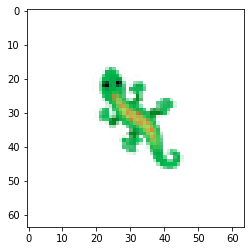

In [4]:
dataset.visualize(0)

### Import NCA

In [5]:
from controllable_nca.image.nca import ControllableImageNCA

import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_embeddings: int, out_channels: int, embedding_dim: int = 32):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding_encoder = nn.Sequential(
            nn.Linear(embedding_dim, 32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32, out_channels, bias=False)
        )
    
    def forward(self, one_hot_encoding: torch.Tensor):
        indices = torch.argmax(one_hot_encoding, -1)
        embeddings = self.embedding(indices)
        return self.embedding_encoder(embeddings)

In [6]:
NUM_HIDDEN_CHANNELS=16

In [7]:
encoder = Encoder(dataset.num_classes, NUM_HIDDEN_CHANNELS, 32)

In [8]:
nca =  ControllableImageNCA(target_shape=dataset.target_size(), encoder=encoder, living_channel_dim=3, num_hidden_channels=NUM_HIDDEN_CHANNELS)

In [9]:
sum(dict((p.data_ptr(), p.numel()) for p in nca.parameters()).values())

12983

### Put in Cuda

In [10]:
device = torch.device('cuda')
dataset.to(device)
nca = nca.to(device)

### Trainer

In [11]:
from controllable_nca.image.trainer import ControllableNCAImageTrainer

In [12]:
trainer = ControllableNCAImageTrainer(nca, dataset, nca_steps=[48, 64], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=128)

Writing to tensorboard_logs/2022-02-08 18:32:56.906229


In [ ]:
trainer.train(batch_size=5, epochs=50000)

loss:0.0067682573571801186--log10loss: